First, let's do word2vec with 'normal' text

In [1]:
from gensim.models.word2vec import Word2Vec
import pandas as pd
import re
import string
from nltk.corpus import stopwords
import numpy as np 

STOP = set(stopwords.words("english"))
REMOVE = set(["!","(",")",":",".",";",",",'"',"?","-",">","_"])


df = pd.read_csv('../Goodreads_visualization/goodreads_export.csv')
cleaned_df = df[df["My Rating"] != 0]


html_clean = re.compile('<.*?>')
gr_clean = re.compile('\[.*?\]')

all_my_words = []

reviews = cleaned_df["My Review"]

num_reviews = 0
num_words = 0
for row in reviews:
    if pd.isnull(row):
        continue
    review = row.lower()
    if not review:
        # empty review
        continue
    # clean strings
    cleaned_review = re.sub(html_clean, '', review)
    cleaned_review = re.sub(gr_clean, '', cleaned_review)
    new_review = []
    for x in cleaned_review.split(' '):
        if x in STOP: continue
        if x in REMOVE: continue
        new_review.append(x)
    new_review = ' '.join(new_review)
    
    all_my_words += new_review.split('.')
    num_reviews += 1



let's put these sentences into a dumb text file for the helper, just as an example

In [2]:
text = open('simple_text.txt','w')
for element in all_my_words:
    text.write('%s.\n'%element)

In [3]:
from gensim.models.word2vec import LineSentence
sentences = LineSentence(text.name) 
model = Word2Vec(sentences, size=100, window=4, min_count=5)

In [4]:
vocab = list(model.vocab.keys())
vocab[:10]

['mirror',
 'anyone',
 'mature',
 'better',
 'translation:',
 'den',
 'games',
 'complete',
 'tried',
 'personal']

In [5]:
model['physics']

array([-0.02717831,  0.00492555, -0.01852022, -0.03654726,  0.02436224,
       -0.02609773, -0.0430923 , -0.01449598, -0.02548516, -0.04809718,
       -0.02736587, -0.00802871,  0.01792513,  0.0039053 ,  0.00633677,
       -0.02472775,  0.03804288,  0.02889261, -0.01918785,  0.00154327,
        0.02631482, -0.01640731,  0.03828493, -0.03271578,  0.01098422,
        0.01972911,  0.00940928,  0.02747699, -0.01830937,  0.02344895,
       -0.00585744, -0.01419545,  0.02279735, -0.00793438, -0.02638387,
       -0.03730087, -0.02485383, -0.00292957, -0.02872095, -0.04057305,
       -0.00734267,  0.00589941, -0.0186944 , -0.00805976,  0.0104247 ,
       -0.00613105, -0.03981143,  0.01222069,  0.0384763 , -0.0377025 ,
       -0.01680348,  0.00324021, -0.01259663,  0.01701536,  0.03354149,
        0.00418017, -0.03244723,  0.02120068,  0.01998114, -0.03953146,
        0.03491039, -0.00787114,  0.00427735, -0.02176348,  0.0122668 ,
        0.02304656,  0.00176654, -0.02162047,  0.01587852,  0.03

In [6]:
model.most_similar_cosmul(positive=['nazis', 'japan'])

[('love', 0.9976211786270142),
 ('make', 0.9976093769073486),
 ('want', 0.9976087212562561),
 ('know', 0.9975837469100952),
 ("it's", 0.9975831508636475),
 ('around', 0.997578501701355),
 ('think', 0.9975727200508118),
 ('never', 0.9975675940513611),
 ('since', 0.9975622296333313),
 ('also', 0.9975539445877075)]

In [7]:
model.similarity('book', 'novel')

0.99935173252540632

Exciting! Are other pairs more dissimilar?

In [8]:
import random
similarities = []
for i in range(1,100):
    one, other = random.choice(vocab), random.choice(vocab)

    similarities.append(model.similarity(one, other))

In [9]:
np.mean(similarities), np.median(similarities)

(0.97674956652823819, 0.98859741308027294)

Welp that's not good. I guess the training corpus is too small...

In [10]:
model.syn0

array([[-0.41777265,  0.11794169, -0.20276248, ..., -0.39055794,
        -0.57785636,  0.08655135],
       [-0.43015233,  0.12541732, -0.20346862, ..., -0.39591387,
        -0.59251708,  0.09074916],
       [-0.4144071 ,  0.12646823, -0.20483989, ..., -0.3875623 ,
        -0.57548046,  0.088502  ],
       ..., 
       [-0.01809407,  0.01045008, -0.01193578, ..., -0.02180701,
        -0.02586695,  0.00793257],
       [-0.02080018,  0.0079154 , -0.00586619, ..., -0.01402574,
        -0.02658108,  0.00172891],
       [-0.01630935,  0.0016155 , -0.00424313, ..., -0.01865236,
        -0.01687454,  0.00377039]], dtype=float32)

The above are the weights you can use in embeddings

-----------------------

Now let's look at DNA!

In [11]:
import dna2vec

First a look at how dna2vec does it:

In [12]:
class Learner:
    def __init__(self, out_fileroot, context_halfsize, gensim_iters, vec_dim):
        self.logger = logbook.Logger(self.__class__.__name__)
        assert(word2vec.FAST_VERSION >= 0)
        self.logger.info('word2vec.FAST_VERSION (should be >= 0): {}'.format(word2vec.FAST_VERSION))
        self.model = None
        self.out_fileroot = out_fileroot
        self.context_halfsize = context_halfsize
        self.gensim_iters = gensim_iters
        self.use_skipgram = 1
        self.vec_dim = vec_dim

        self.logger.info('Context window half size: {}'.format(self.context_halfsize))
        self.logger.info('Use skipgram: {}'.format(self.use_skipgram))
        self.logger.info('gensim_iters: {}'.format(self.gensim_iters))
        self.logger.info('vec_dim: {}'.format(self.vec_dim))

    def train(self, kmer_seq_generator):
        self.model = word2vec.Word2Vec(
            sentences=kmer_seq_generator,
            size=self.vec_dim,
            window=self.context_halfsize,
            min_count=5,
            workers=4,
            sg=self.use_skipgram,
            iter=self.gensim_iters)

        # self.logger.info(model.vocab)

    def write_vec(self):
        out_filename = '{}.w2v'.format(self.out_fileroot)
        self.model.save_word2vec_format(out_filename, binary=False)


--------------------------------

The trained table looks like this (some random input data from my projects)

    1344 12
    AAA 0.798623 0.340167 -0.106002 0.479023 -0.512316 -0.204932 -0.909642 0.929776 -0.526895 -0.487418 0.652579 -0.041673
    TTT -0.430355 0.507353 0.204868 -0.396864 0.594459 -0.879607 -0.070906 1.065970 -0.216547 0.540595 0.742848 -0.213119
    AAAA 0.916474 0.360498 -0.201165 0.450726 -0.627372 -0.232655 -1.043633 1.079020 -0.585594 -0.505746 0.719241 0.046239
    TTTT -0.604012 0.578508 0.240181 -0.476954 0.605583 -0.960840 -0.079009 1.184651 -0.243861 0.608393 0.795853 -0.286772
    TTTTT -0.625304 0.602461 0.296689 -0.482694 0.649928 -0.997988 -0.065473 1.091690 -0.250700 0.741902 0.868796 -0.313275
    AAAAA 1.029531 0.364190 -0.265436 0.437347 -0.723385 -0.299899 -1.087821 1.122777 -0.636950 -0.578345 0.761875 0.069213
    ATT -0.490559 0.496848 -0.300972 -0.190906 0.170407 -0.613530 -0.456763 0.833760 -0.632226 0.541257 0.759477 -0.018878
    AAT 0.028495 0.360433 -0.458956 0.125764 -0.013972 -0.417648 -0.925049 0.953009 -0.534955 -0.186829 0.600540 0.346013


Now load this into python, and later Keras

In [13]:
from gensim.models import word2vec
word_vectors = word2vec.Word2Vec.load_word2vec_format('./dna2vec-20170621-0833-k3to5-12d-4c-6Mbp-sliding-nqR.w2v')

In [14]:
word_vectors.syn0

array([[ 0.79862303,  0.34016699, -0.106002  , ..., -0.487418  ,
         0.65257901, -0.041673  ],
       [-0.43035501,  0.50735301,  0.204868  , ...,  0.540595  ,
         0.74284798, -0.213119  ],
       [ 0.91647398,  0.36049801, -0.20116501, ..., -0.50574601,
         0.71924102,  0.046239  ],
       ..., 
       [ 0.76107103,  0.83726299, -0.28360999, ...,  0.170651  ,
         0.103405  , -0.71069998],
       [ 0.89855403,  0.8168    , -0.37794799, ...,  0.32508701,
         0.61397099, -0.39332399],
       [ 0.814578  ,  0.86901098, -0.498676  , ...,  0.21636599,
         0.474002  , -0.49750999]], dtype=float32)

That's the weights for Keras!

In [15]:
word_vectors.syn0.shape

(1344, 12)

In [16]:
word_vectors.most_similar(positive=['AAA'], negative=['TTT'])

[('AAAAA', 0.6307621002197266),
 ('AAAA', 0.6196656227111816),
 ('AAAGG', 0.597085177898407),
 ('GAAAA', 0.5835936069488525),
 ('AGGAA', 0.5639663338661194),
 ('AAAAG', 0.5594942569732666),
 ('CAAAA', 0.5461493730545044),
 ('GAAA', 0.5357614159584045),
 ('AAAAC', 0.5209873914718628),
 ('GGAAA', 0.5187864303588867)]

In [17]:
word_vectors.most_similar(positive=['AAA'])

[('AAAA', 0.997001051902771),
 ('AAAAA', 0.9936331510543823),
 ('AATAA', 0.9240623712539673),
 ('TAAAA', 0.9036520719528198),
 ('TAAA', 0.8960134983062744),
 ('GAAAA', 0.8902114629745483),
 ('AAAT', 0.8800619840621948),
 ('AAAAT', 0.8783645629882812),
 ('GAAA', 0.8714821338653564),
 ('CAAAA', 0.869722843170166)]

In [18]:
word_vectors.similarity('AGAAT','AAGTA')

0.37256660513788192

More promising! At least no 99% as above....

----------------

Let's compare with Needleman Wunsch, an alignment algorithm

In [19]:
from Bio import pairwise2
pairwise2.align.globalxx("AGAAT", "AAGTA")

[('AGAA-T-', '--AAGTA', 3.0, 0, 7),
 ('AGAA-T-', 'A--AGTA', 3.0, 0, 7),
 ('AGAA-T-', 'A-A-GTA', 3.0, 0, 7),
 ('AGAAT-', 'A-AGTA', 3.0, 0, 6),
 ('A-GAAT-', 'AAG--TA', 3.0, 0, 7),
 ('-AGAAT-', 'AAG--TA', 3.0, 0, 7),
 ('AGA--AT', 'A-AGTA-', 3.0, 0, 7),
 ('A-GA-AT', 'AAG-TA-', 3.0, 0, 7),
 ('-AGA-AT', 'AAG-TA-', 3.0, 0, 7),
 ('A-GAAT', 'AAGTA-', 3.0, 0, 6),
 ('-AGAAT', 'AAGTA-', 3.0, 0, 6),
 ('A-G-AAT', 'AAGTA--', 3.0, 0, 7),
 ('-AG-AAT', 'AAGTA--', 3.0, 0, 7)]

In [20]:
3.0/7

0.42857142857142855

Kind of close? 42 % to 37%....

In [21]:
nws = []
sims = []

counter = 0
for a in word_vectors.vocab:
    # a = ACCG, GGGGT, TGT, CAG, .....
    for b in word_vectors.vocab:
        if a == b: continue
        new_score = pairwise2.align.globalxx(a, b)[0]
        # ('CCAC--T', '-CA-AAT', 3.0, 0, 7)
        score, length = new_score[2], new_score[-1]
        
        new_score = score/length # 3 / 7 = 0.42
    
        similarity = word_vectors.similarity(a, b) # 0.3
        nws.append(new_score)
        sims.append(similarity)
            
    counter += 1
    if counter == 50: break

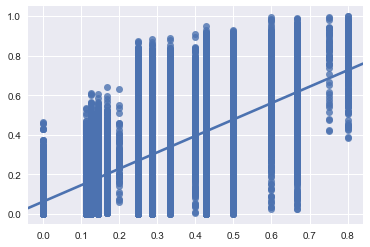

In [22]:
import seaborn as sns

%matplotlib inline
sns.regplot(np.abs(nws), np.abs(sims));

In [23]:
import scipy
scipy.stats.pearsonr(nws, sims)

(0.57407078984816717, 0.0)

wat. was expecting something higher

In [24]:
from dna2vec.multi_k_model import MultiKModel

filepath = 'dna2vec-20170621-0833-k3to5-12d-4c-6Mbp-sliding-nqR.w2v'
mk_model = MultiKModel(filepath)


In [25]:
weights = word_vectors.syn0

from keras.layers import Embedding
from keras.engine import Input

layer = Embedding(input_dim=weights.shape[0], output_dim=weights.shape[1], weights=[weights], trainable=False)


Using TensorFlow backend.


IMPORTANT to set trainable to False, else Keras is allowed to change our word2vec input weights!

We can either use an LSTM or convolutional layers here. Let's steal from their blog and use Conv1D

https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html